In [1]:
# Importing some important libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
%matplotlib inline

In [85]:
data = pd.read_csv('train.csv')
data_copy = data.copy()
data_test = pd.read_csv('test.csv')
data_test_copy = data_test.copy()

In [86]:
# Lots of duplicates

In [87]:
# There are a lot of duplicates in this data. Oddly enough, I noticed that simply running data.drop_duplicates() 
# did not remove all duplicates, which is the result of some columns between the duplicated rows differeing.
# Nevertheless, the fact that the "Description" columns were identical was a dead giveaway that these were not a 
# different reviews.

In [88]:
data[data.duplicated('review_description',keep=False)].sort_values('review_description').head(5)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
53655,@wawinereport,US,Roza Ridge 2010 Malbec (Rattlesnake Hills),"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Roza Ridge,Malbec
73628,@wawinereport,US,Roza Ridge 2010 Malbec (Rattlesnake Hills),"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Roza Ridge,Malbec
64962,@wawinereport,US,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Ross Andrew,Rosé
81272,@wawinereport,US,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Ross Andrew,Rosé
45297,@vossroger,France,Château Haut-Sarpe 2008 Barrel sample (Saint-...,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Château Haut-Sarpe,Bordeaux-style Red Blend


In [89]:
# I decided to drop all duplicates based on the description column alone and subsequently all missing price data:

In [90]:
data = data.drop_duplicates('review_description')
data = data[pd.notnull(data.price)]
data.shape


(72344, 12)

In [91]:
data_test = data_test.drop_duplicates('review_description')
data_test = data_test[pd.notnull(data_test.price)]
data_test.shape


(18976, 11)

In [92]:
# Exploratory Analysis

In [93]:
# Not surprisingly, there's a significant correlation between the cost of wine and its rating, namely theres
# an average $1.001 increase for every one point incrase in rating.

Pearson Correlation: (0.41159866633537157, 0.0)
                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.423
Model:                            OLS   Adj. R-squared (uncentered):              0.423
Method:                 Least Squares   F-statistic:                          5.307e+04
Date:                Fri, 08 May 2020   Prob (F-statistic):                        0.00
Time:                        20:40:43   Log-Likelihood:                     -4.0712e+05
No. Observations:               72344   AIC:                                  8.142e+05
Df Residuals:                   72343   BIC:                                  8.142e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      

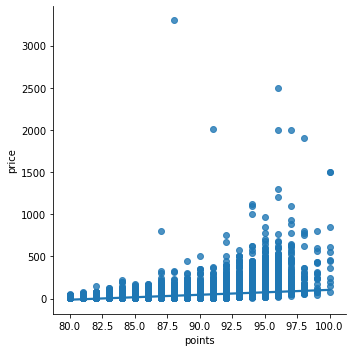

In [94]:
from scipy.stats import pearsonr
import statsmodels.api as sm
print("Pearson Correlation:", pearsonr(data.price, data.points))
print(sm.OLS(data.points, data.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=data)


In [95]:
# Plotting all the countries, there's some odd plots as a result of low sample size for certain countries.



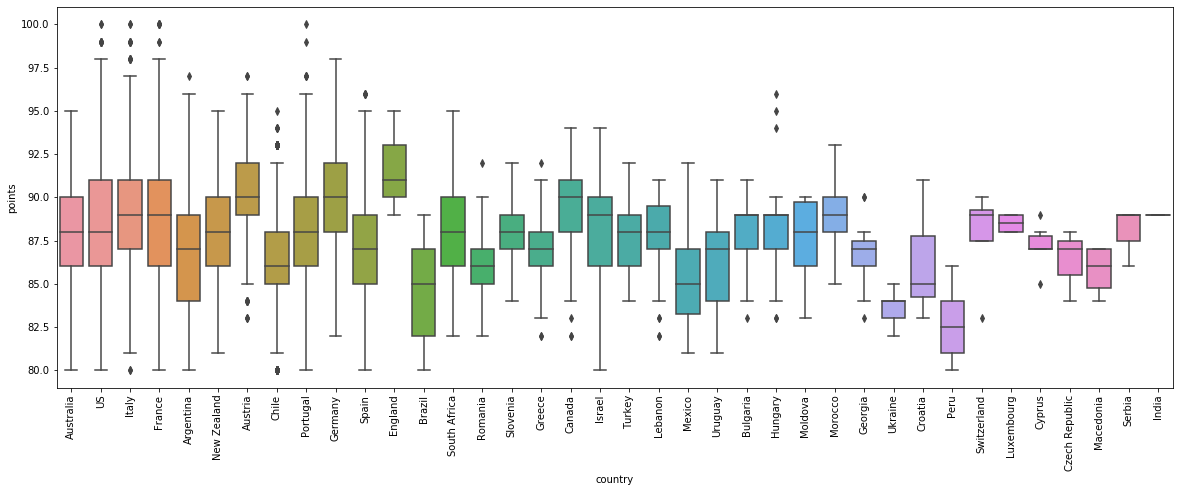

In [96]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=data, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [97]:
data.country.value_counts()[:17]

US              36108
France          11870
Italy            7408
Chile            2708
Portugal         2642
Spain            2541
Argentina        2399
Austria          1491
Germany          1442
New Zealand      1004
Australia         957
South Africa      622
Israel            293
Canada            151
Greece            133
Bulgaria           91
Romania            69
Name: country, dtype: int64

In [98]:
# After removing all countries with less than 100 observations, it appears that Germany, Austria, and Canada
# have the highest median scores(points). However, the distribution overall appears to be fairly uniform.

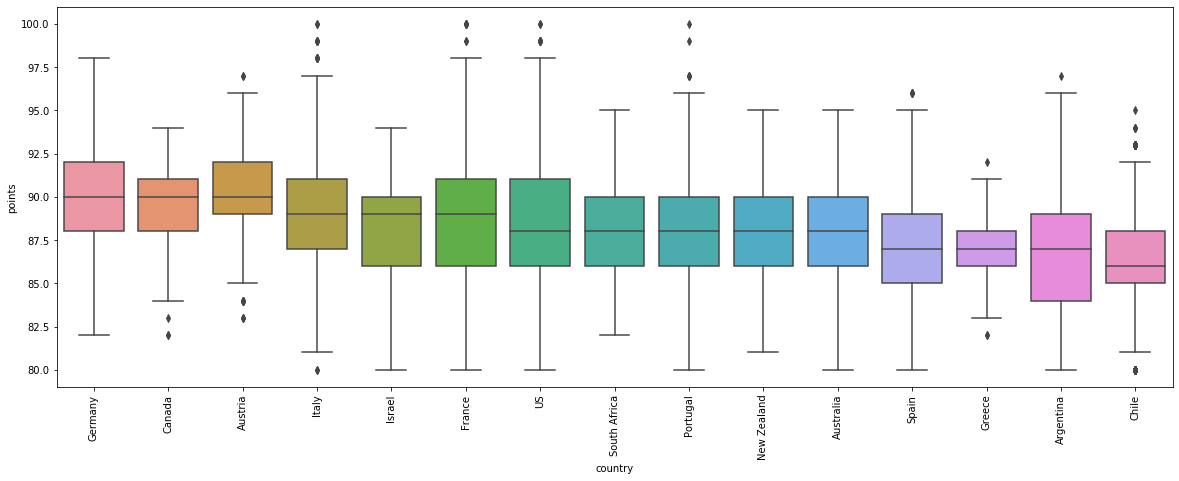

In [99]:
country=data.groupby('country').filter(lambda x: len(x) >100)
df2 = pd.DataFrame({col:vals['points'] for col,vals in country.groupby('country')})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=country, order=meds.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

In [100]:
# Below are the average wine prices sorted by median (highest to lowest) in order to evaluate price distortions 
# due to outliers.

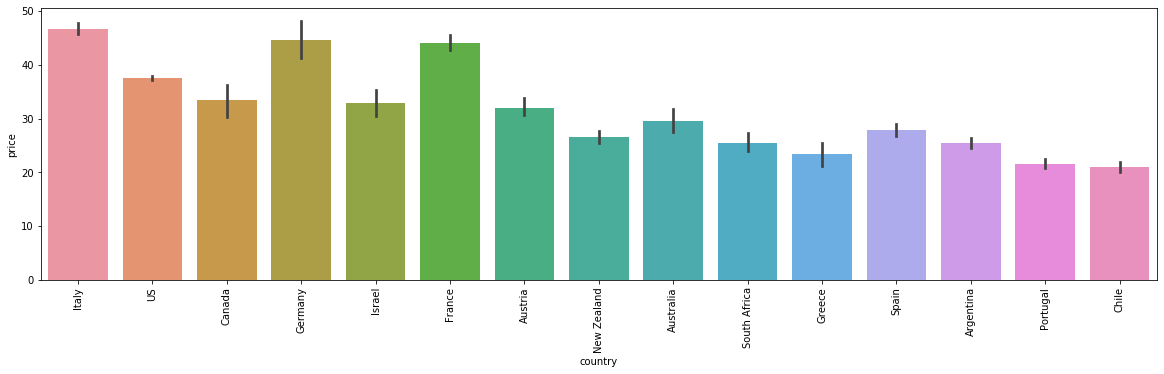

In [101]:
df3 = pd.DataFrame({col:vals['price'] for col,vals in country.groupby('country')})
meds2 = df3.median()
meds2.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,5))
chart = sns.barplot(x='country',y='price', data=country, order=meds2.index, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [102]:
# medians for the above barplot
print(meds2)

Italy           35.0
US              30.5
Canada          30.0
Germany         28.0
Israel          27.0
France          25.0
Austria         25.0
New Zealand     20.0
Australia       20.0
South Africa    19.0
Greece          19.0
Spain           18.0
Argentina       17.0
Portugal        15.0
Chile           15.0
dtype: float64


In [103]:
# There's a large variety of wines in the dataset (I never knew there was so many!) However, there's an
# exponential decline in the number of observations for each wine type, and since we'll be attempting to use 
# these labels to classify our model, I'll be dropping any wine types with less than 200 observations, for the 
# reason that I don't believe there's enough data in these buckets to generate an accuarte model for predicting 
# their respective wine type

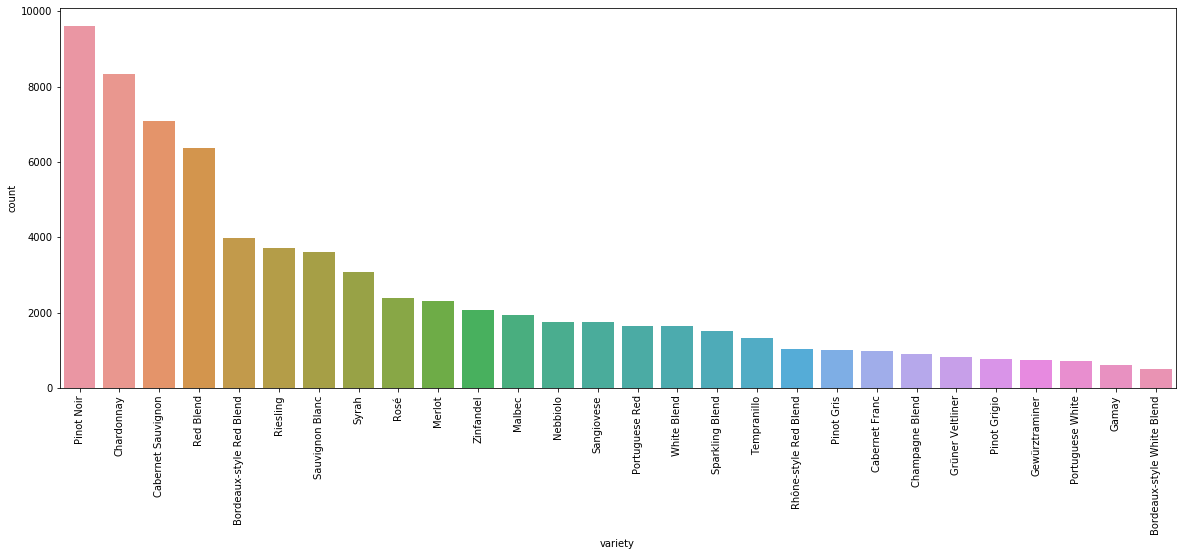

In [104]:
data = data.groupby('variety').filter(lambda x: len(x) >100)
list = data.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=data, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

In [105]:
# Below is a boxplot chart containing all wine varieties (w/ >200 observations) and their respective point
# distributions. Sangiovese Grosso (never tried it) appears to have the highest median score of all wines. There 
# are some interesting dips occuring after Champagne Blend, Shiraz, Cabernet Sauvignon (my favorite), and 
# Nero d'Avola. Of interest is Merlot, which tends to have a large number of highly reviewed outliers. Despite 
# these slight variations, overall the point distibution is basically uniform.

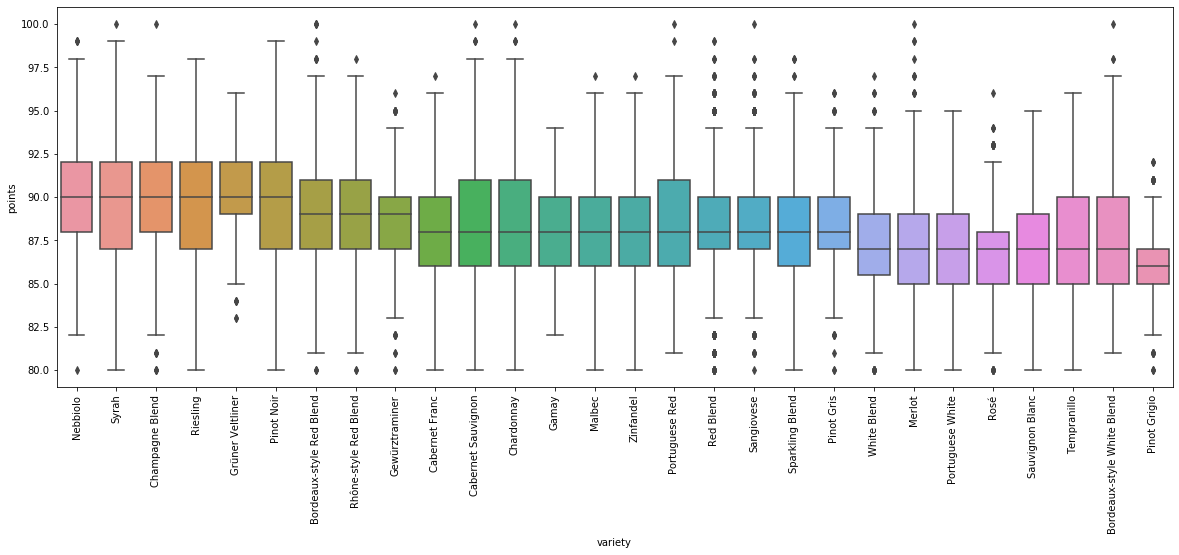

In [106]:
data = data.groupby('variety').filter(lambda x: len(x) >200)

df4 = pd.DataFrame({col:vals['points'] for col,vals in data.groupby('variety')})
meds3 = df4.median()
meds3.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='variety',y='points', data=data, order=meds3.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

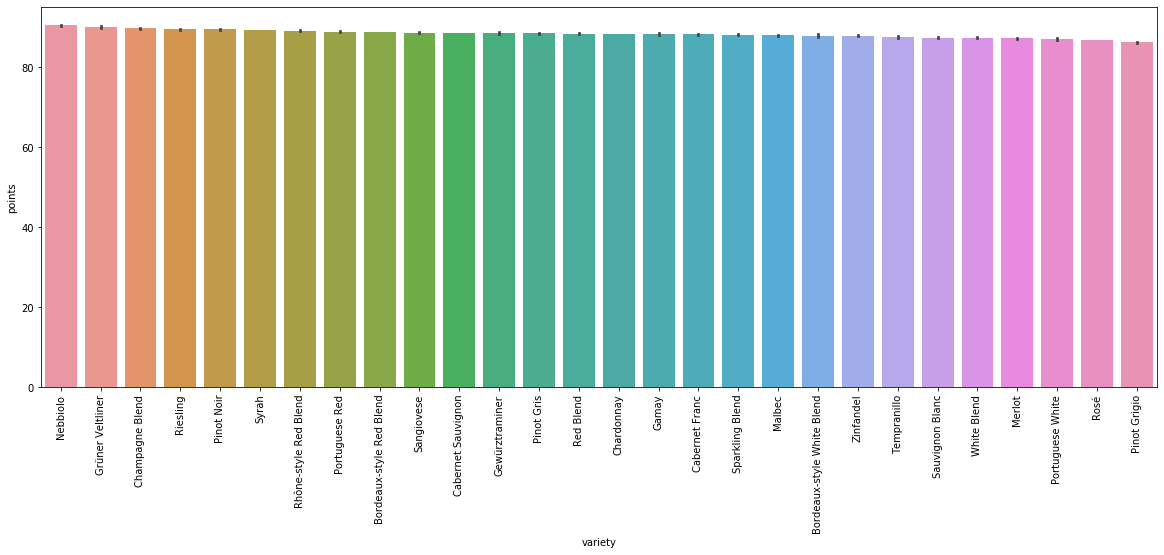

In [107]:
df5 = pd.DataFrame({col:vals['points'] for col,vals in data.groupby('variety')})
mean1 = df5.mean()
mean1.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='points', data=data, order=mean1.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

In [108]:
# It's definitely not the same story when you look at price. There's clear variation in here, which may help 
# in predicting the wine type.

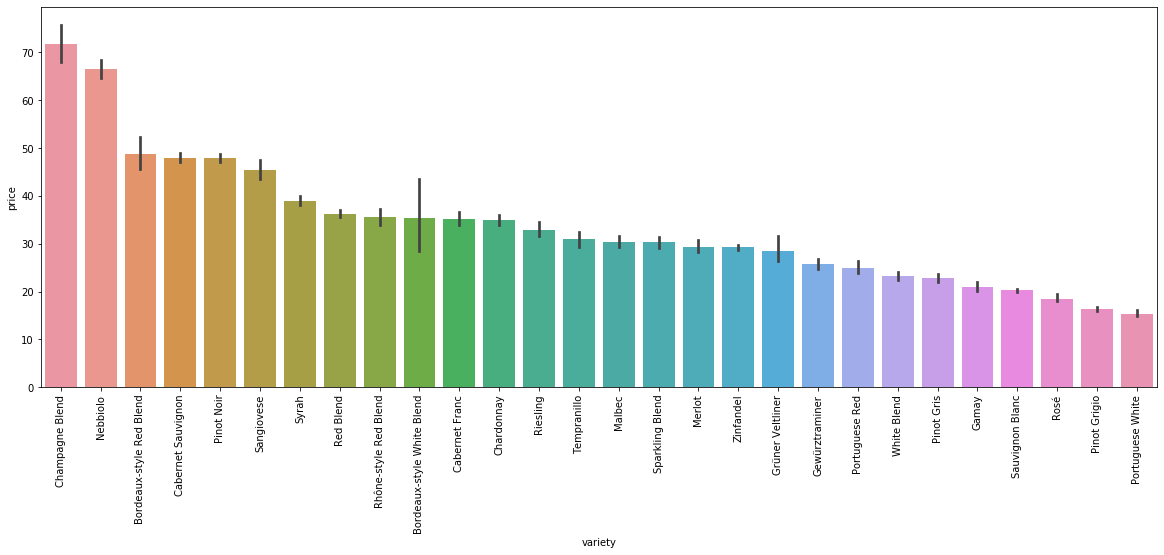

In [109]:
df6 = pd.DataFrame({col:vals['price'] for col,vals in data.groupby('variety')})
mean2 = df6.mean()
mean2.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='price', data=data, order=mean2.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()


In [110]:
dataset = data_copy.copy()

In [111]:
# Imporeting some important libraries

In [112]:

from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
sw = stopwords.words('english')

In [113]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63264 non-null  object 
 1   country             82622 non-null  object 
 2   review_title        82657 non-null  object 
 3   review_description  82657 non-null  object 
 4   designation         59010 non-null  object 
 5   points              82657 non-null  int64  
 6   price               77088 non-null  float64
 7   province            82622 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82657 non-null  object 
 11  variety             82657 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [114]:
dataset.dropna(axis=0)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
6,@wawinereport,US,Gordon Estate 2012 Tradition Red (Columbia Val...,"Half Syrah and half Cabernet Sauvignon, with 4...",Tradition,91,45.0,Washington,Columbia Valley (WA),Columbia Valley,Gordon Estate,Red Blend
7,@vboone,US,Rock Wall 2014 Monte Rosso Reserve Zinfandel (...,"High-toned red fruit stars in this wine, a nic...",Monte Rosso Reserve,90,50.0,California,Sonoma County,Sonoma,Rock Wall,Zinfandel
8,@paulgwine,US,Elizabeth Chambers 2014 Falcon Glen Vineyard P...,"Displaying typical McMinnville AVA subtlety, t...",Falcon Glen Vineyard,91,48.0,Oregon,McMinnville,Willamette Valley,Elizabeth Chambers,Pinot Noir
10,@vboone,US,Cuvaison 2014 Estate Grown Sauvignon Blanc (Ca...,With an alluring bouquet of fresh-cut jasmine ...,Estate Grown,90,18.0,California,Carneros,Napa-Sonoma,Cuvaison,Sauvignon Blanc
34,@paulgwine,US,Durant 2013 Raven Chardonnay (Dundee Hills),"Peach pit, apple and pear fruit flavors combin...",Raven,92,25.0,Oregon,Dundee Hills,Willamette Valley,Durant,Chardonnay
...,...,...,...,...,...,...,...,...,...,...,...,...
82630,@vboone,US,Yorkville Cellars 2010 Randle Hill Vineyard Sa...,"A glass of pretty aromatics, grapefruit and or...",Randle Hill Vineyard,88,18.0,California,Yorkville Highlands,North Coast,Yorkville Cellars,Sauvignon Blanc
82632,@vboone,US,un4seen 2009 Red blend Red (California),"Dark like a cave in color, this big red blend ...",Red blend,85,10.0,California,California,California Other,un4seen,Red Blend
82639,@paulgwine,US,Archery Summit 2012 Red Hills Estate Pinot Noi...,"Showing a light whiff of funk, this seems a bi...",Red Hills Estate,92,85.0,Oregon,Dundee Hills,Willamette Valley,Archery Summit,Pinot Noir
82641,@gordone_cellars,US,The Withers Winery 2013 Mr. Burgess Red (El Do...,"Imposing, concentrated and tannic, this Syrah-...",Mr. Burgess,92,36.0,California,El Dorado,Sierra Foothills,The Withers Winery,Rhône-style Red Blend


In [115]:
input_data = dataset['review_description']
output_data = dataset['variety']

In [116]:
# How many varieties of wine do we have in this dataset?

In [117]:
print ('There are %d varieties of wines in this dataset' % len(set(output_data)))

There are 28 varieties of wines in this dataset


In [118]:
# Since we have 28 varieties of wines in the dataset, the enconder is going from 0 to 27

In [119]:
labelEncoder = LabelEncoder()
output_data = labelEncoder.fit_transform(output_data)
output_data

array([ 5, 17, 11, ...,  6,  0,  3])

In [120]:
# Now it is time to clean the description data

In [121]:
input_data = input_data.str.lower()

In [122]:
list_aux = []
for phase_word in input_data:
    list_aux.append(' '.join([re.sub('[0-9\W_]', '', word) for word in phase_word.split() if not word in sw]))
input_data = list_aux

In [123]:
countVectorizer = CountVectorizer()
input_data = countVectorizer.fit_transform(input_data)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2) 

In [125]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=len(countVectorizer.get_feature_names())))
model.add(Dense(units=output_data.max()+1, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, verbose=1)

Epoch 1/2
66125/66125 [==============================] - 96s 1ms/step - loss: 1.2490 - accuracy: 0.6361
Epoch 2/2
66125/66125 [==============================] - 95s 1ms/step - loss: 0.6579 - accuracy: 0.7964


In [126]:
scores = model.evaluate(X_test, y_test, verbose=1)
print ('The accuracy of the model is %s' % scores[1])

16532/16532 [==============================] - 4s 224us/step
The accuracy of the model is 0.7046939134597778


In [127]:
dataset1 = data_test_copy.copy()

In [128]:
dataset1.dropna(axis=0)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
14,@paulgwine,US,Brittan Vineyards 2014 Gestalt Block Pinot Noi...,This black-fruited offering has the winery's s...,Gestalt Block,93,60.0,Oregon,McMinnville,Willamette Valley,Brittan Vineyards
16,@vboone,US,Mounts 2014 Estate Grown Cabernet Sauvignon (D...,"This is a seductive wine, concentrated and ful...",Estate Grown,88,45.0,California,Dry Creek Valley,Sonoma,Mounts
18,@paulgwine,US,Novelty Hill 2009 Stillwater Creek Vineyard Ca...,Novelty Hill's estate-grown Cabernet Sauvignon...,Stillwater Creek Vineyard,89,30.0,Washington,Columbia Valley (WA),Columbia Valley,Novelty Hill
26,@vboone,US,Medlock Ames 2013 Heritage Merlot (Alexander V...,"Made with 21% Cabernet Sauvignon, 4% Malbec an...",Heritage,87,50.0,California,Alexander Valley,Sonoma,Medlock Ames
...,...,...,...,...,...,...,...,...,...,...,...
20653,@wawinereport,US,Almquist 2010 Garagiste Rosso Red (Washington),This wine is a blend of Sangiovese (65%) and B...,Garagiste Rosso,90,20.0,Washington,Washington,Washington Other,Almquist
20654,@wawinereport,US,J. Bookwalter 2015 Suspense Conner Lee Vineyar...,"Aromas of herb, freshly sliced green pepper, c...",Suspense Conner Lee Vineyard,90,60.0,Washington,Columbia Valley (WA),Columbia Valley,J. Bookwalter
20659,@mattkettmann,US,Blackjack 2012 Black Cap Reserve Chardonnay (S...,The inviting scents of melting butter on hot d...,Black Cap Reserve,89,48.0,California,Santa Barbara County,Central Coast,Blackjack
20660,@gordone_cellars,US,Yorkville Cellars 2013 Rennie Vineyard Caberne...,"Clearly focused and fruit-driven, this wine ha...",Rennie Vineyard,91,34.0,California,Yorkville Highlands,North Coast,Yorkville Cellars


In [129]:
input_data1 = dataset1['review_description']

In [130]:
input_data1 = input_data1.str.lower()

In [131]:
list_aux = []
for phase_word in input_data1:
    list_aux.append(' '.join([re.sub('[0-9\W_]', '', word) for word in phase_word.split() if not word in sw]))
input_data1 = list_aux

In [132]:
countVectorizer = CountVectorizer()
input_data1 = countVectorizer.fit_transform(input_data1)

In [133]:
## So by using the above keras model we achieve accuracy of 70.46%

In [134]:
## similarly we can use model.predict_classes to predict variety of test dataset.

In [ ]:
## Thank you